# Klasyfikacja świeżych i zgniłych truskawek z wykorzystaniem analizy obrazu oraz algorytmu Random Forest
##### Nazwa przedmiotu: Analiza danych multimedialnych
##### Autorzy: Michał Kos i Tomasz Opałka
##### Prowadzący: dr inż. Łukasz Jeleń
##### Numer grupy zajęciowej: SliUM1 O

# Wstęp
Automatyczna ocena jakości owoców jest istotnym zagadnieniem w przemyśle spożywczym oraz rolnictwie. Ręczna kontrola świeżości produktów jest czasochłonna, subiektywna i podatna na błędy. Z tego powodu coraz częściej stosuje się metody analizy obrazu oraz uczenia maszynowego w celu automatycznej klasyfikacji produktów spożywczych.
Celem niniejszego projektu jest opracowanie systemu umożliwiającego rozróżnianie świeżych i zgniłych truskawek na podstawie zdjęć. W projekcie wykorzystano techniki przetwarzania obrazu, ekstrakcję cech wizualnych oraz klasyfikator Random Forest. Szczególny nacisk położono na analizę koloru oraz tekstury owocu.

# Opis danych
Dane wejściowe stanowią obrazy truskawek podzielone na dwie klasy:
świeże truskawki (klasa 0)
zgniłe truskawki (klasa 1)
Każde zdjęcie przedstawia pojedynczą truskawkę na tle, które może zawierać szumy lub inne elementy. Rozmiary i warunki oświetleniowe zdjęć mogą się różnić, co stanowi dodatkowe wyzwanie dla modelu klasyfikacyjnego.
Dane zostały podzielone na zbiór treningowy (70%) oraz testowy (30%) z zachowaniem proporcji klas (stratyfikacja).

# Opis i implementacja metod
##### Segmentacja truskawki
Pierwszym etapem przetwarzania obrazu jest wydzielenie obszaru truskawki. W tym celu:
obraz jest skalowany do rozmiaru 128×128 pikseli,
konwertowany do przestrzeni barw HSV,
wykorzystywane są dwa zakresy barwy czerwonej (dla niskich i wysokich wartości Hue),
stosowane są operacje morfologiczne (otwarcie i domknięcie) w celu redukcji szumu.
Wynikiem jest maska binarna określająca obszar truskawki.
##### Ekstrakcja cech
Dla wysegementowanego obszaru truskawki wyznaczane są następujące cechy:
1. Cechy kolorystyczne
średnia i odchylenie standardowe wartości RGB,
średnia wartość kanałów HSV,
histogram kolorów HSV (8 koszy na kanał),
współczynnik czerwieni (stosunek intensywności kanału czerwonego do zielonego).
2. Cechy teksturalne – LBP
Zastosowano Local Binary Patterns (LBP) w wariancie „uniform”:
promień: 3,
liczba punktów: 24,
histogram wzorców LBP obliczany tylko dla obszaru truskawki.
3. Cechy teksturalne – GLCM
Na podstawie macierzy współwystępowania poziomów szarości (GLCM)

##### Klasyfikator Random Forest
Do klasyfikacji wykorzystano algorytm Random Forest z następującymi parametrami:
liczba drzew: 400,
maksymalna głębokość drzewa: 20,
minimalna liczba próbek w liściu: 3,
zrównoważenie klas (class_weight = "balanced").
Model został wytrenowany na zbiorze treningowym i zapisany do pliku best_model.pkl.

# Wyniki
Model osiągnął następujące wyniki na zbiorze testowym:
Accuracy: 86,6%
##### Raport klasyfikacji

| Klasa  | Precision | Recall | F1-score |
|--------|-----------|--------|----------|
| świeża | 0.85      | 0.89   | 0.87     |
| zgniła | 0.89      | 0.84   | 0.86     |

# Dyskusja wyników
Uzyskane wyniki wskazują, że zaproponowana metoda skutecznie rozróżnia świeże i zgniłe truskawki. Wysoka skuteczność dla klasy „świeża” sugeruje, że cechy kolorystyczne są bardzo dobrze dopasowane do charakterystyki zdrowych owoców.
Niższy recall dla klasy „zgniła” może wynikać z podobieństwa wizualnego lekko nadpsutych owoców do świeżych i nierównomiernego rozkładu cech zgniłych fragmentów.
Zastosowanie GLCM oraz LBP znacząco poprawia zdolność modelu do analizy tekstury, co jest kluczowe przy wykrywaniu oznak gnicia.

# Podsumowanie i wnioski
W ramach projektu opracowano kompletny system do klasyfikacji świeżości truskawek na podstawie obrazów. Połączenie segmentacji koloru, analizy tekstury oraz klasyfikatora Random Forest pozwoliło uzyskać wysoką skuteczność klasyfikacji.

# Bibliografia 
1. Otsu, N. (1979). A threshold selection method from gray-level histograms. IEEE Transactions on Systems, Man, and Cybernetics (teoria dla maskowania i progowania obrazu)
2. Reddit i github (inspirowanie się róznymi modelami i rozwiązaniami)

### Klasyfikacja świeżych i zgniłych truskawek z wykorzystaniem analizy obrazu oraz algorytmu Random Forest

In [ ]:
#import potrzebnych bibliotek
import os
import cv2
import numpy as np
import joblib
import matplotlib.pyplot as plt
from skimage.feature import local_binary_pattern
#glcm
from skimage.feature import graycomatrix, graycoprops

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

from io import BytesIO
from PIL import Image
from ipywidgets import FileUpload, VBox, Output
from IPython.display import display


In [31]:
#resize zdjecia, a nastepnie ustawienie obszaru ktorym jestesmy zaintetesowani (odciebie czerwonosci)
#to co sie kwalifikuje pod kolor czerwony jest brane za truskawke i znakowane jako biale, a to co nie jako czarne (szum)
def extract_strawberry(img):
    img = cv2.resize(img, (128, 128))
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    lower_red1 = np.array([0, 50, 50])
    upper_red1 = np.array([10, 255, 255])
    lower_red2 = np.array([170, 50, 50])
    upper_red2 = np.array([180, 255, 255])

    mask = cv2.inRange(hsv, lower_red1, upper_red1) + \
           cv2.inRange(hsv, lower_red2, upper_red2)

    kernel = np.ones((5, 5), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

    strawberry = cv2.bitwise_and(img, img, mask=mask)
    return strawberry, mask


In [ ]:
#histogram
def color_histogram(hsv, mask, bins=8):
    h, s, v = cv2.split(hsv)

    hist_h = cv2.calcHist([h], [0], mask, [bins], [0, 180])
    hist_s = cv2.calcHist([s], [0], mask, [bins], [0, 256])
    hist_v = cv2.calcHist([v], [0], mask, [bins], [0, 256])

    hist = np.concatenate([hist_h, hist_s, hist_v]).flatten()
    hist /= (np.sum(hist) + 1e-6)

    return hist

In [ ]:
radius = 3 # promień otoczenia
n_points = 8 * radius # liczba punktów kontrolnych na okręgu. Im więcej punktów, tym dokładniejszy opis tekstury (np. chropowatości skórki)
METHOD = 'uniform'

def extract_features(img, return_glcm=False):
    strawberry, mask = extract_strawberry(img)
    mask_pixels = mask > 0

    if np.sum(mask_pixels) < 100:
        return None

    hsv = cv2.cvtColor(strawberry, cv2.COLOR_BGR2HSV)
    gray = cv2.cvtColor(strawberry, cv2.COLOR_BGR2GRAY)

    mean_color = np.mean(strawberry[mask_pixels], axis=0)
    color_std = np.std(strawberry[mask_pixels], axis=0)
    mean_hsv = np.mean(hsv[mask_pixels], axis=0)

    lbp = local_binary_pattern(gray, n_points, radius, METHOD)
    lbp_masked = lbp[mask_pixels]
    texture_lbp, _ = np.histogram(
        lbp_masked,
        bins=np.arange(0, n_points + 3),
        density=True
    )

    red_ratio = mean_color[2] / (mean_color[1] + 1)
    hist = color_histogram(hsv, mask)

    glcm_features, glcm = extract_glcm_features(gray, mask)

    feat = np.hstack([
        mean_color,
        color_std,
        mean_hsv,
        texture_lbp,
        glcm_features,
        red_ratio,
        hist
    ])

    if return_glcm:
        return feat, glcm
    return feat


In [34]:
def load_images_from_folder(folder, label):
    features, labels = [], []

    for file in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, file))
        if img is None:
            continue

        feat = extract_features(img)
        if feat is None:
            continue

        features.append(feat)
        labels.append(label)

    return features, labels


In [35]:
def extract_glcm_features(gray, mask):
    ys, xs = np.where(mask > 0)
    gray_crop = gray[min(ys):max(ys), min(xs):max(xs)]

    gray_q = (gray_crop / 16).astype(np.uint8)  # 16 poziomów

    glcm = graycomatrix(
        gray_q,
        distances=[1],
        angles=[0, np.pi/4, np.pi/2, 3*np.pi/4],
        levels=16,
        symmetric=True,
        normed=True
    )

    props = ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation']
    features = np.array([graycoprops(glcm, p).mean() for p in props])

    return features, glcm


In [ ]:
#random forest klasyfikator
#na koncu wynik metryk
fresh_path = "data/fresh"
rotten_path = "data/rotten"

X1, y1 = load_images_from_folder(fresh_path, 0)
X2, y2 = load_images_from_folder(rotten_path, 1)

X = np.vstack([X1, X2])
y = np.hstack([y1, y2])

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    stratify=y,
    random_state=42
)

model = RandomForestClassifier(\
    n_estimators=400,
    max_depth=20,
    min_samples_leaf=3,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

joblib.dump(model, "best_model.pkl")
print("Model zapisany jako best_model.pkl")



Accuracy: 0.8657718120805369
              precision    recall  f1-score   support

           0       0.85      0.89      0.87        75
           1       0.89      0.84      0.86        74

    accuracy                           0.87       149
   macro avg       0.87      0.87      0.87       149
weighted avg       0.87      0.87      0.87       149

Model zapisany jako best_model.pkl


<Figure size 500x500 with 0 Axes>

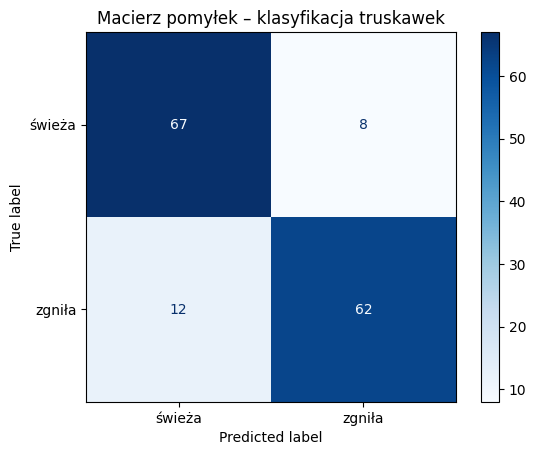

In [37]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Obliczenie macierzy pomyłek
cm = confusion_matrix(y_test, y_pred)

# Wizualizacja
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["świeża", "zgniła"]
)

plt.figure(figsize=(5,5))
disp.plot(cmap="Blues", values_format="d")
plt.title("Macierz pomyłek – klasyfikacja truskawek")
plt.show()


Układ macierzy:
TN	FP
FN	TP

Model dobrze rozpoznaje świeże truskawki
Co czwarta zgniła truskawka przechodzi jako świeża

In [38]:
model = joblib.load("best_model.pkl")
CLASS_NAMES = ["świeża", "zgniła"]

uploader = FileUpload(accept="image/*", multiple=False)
output = Output()

def on_upload_change(change):
    output.clear_output()

    for f in uploader.value:
        img_pil = Image.open(BytesIO(f["content"])).convert("RGB")
        img = cv2.cvtColor(np.array(img_pil), cv2.COLOR_RGB2BGR)

        feat, glcm = extract_features(img, return_glcm=True)
        pred = model.predict([feat])[0]
        prob = model.predict_proba([feat])[0][pred]

        strawberry, mask = extract_strawberry(img)

        with output:
            plt.figure(figsize=(16,4))

            plt.subplot(1,4,1)
            plt.imshow(img_pil)
            plt.title("Oryginał")
            plt.axis("off")

            plt.subplot(1,4,2)
            plt.imshow(mask, cmap="gray")
            plt.title("Maska")
            plt.axis("off")

            plt.subplot(1,4,3)
            plt.imshow(cv2.cvtColor(strawberry, cv2.COLOR_BGR2RGB))
            plt.title("Truskawka")
            plt.axis("off")

            plt.subplot(1,4,4)
            plt.imshow(np.log1p(glcm[:, :, 0, 0]), cmap="hot")
            plt.title("GLCM (log scale)")
            plt.colorbar()

            plt.show()

            print(f"Predykcja: {CLASS_NAMES[pred]}")
            print(f"Pewność: {prob:.2%}")

uploader.observe(on_upload_change, names="value")
display(VBox([uploader, output]))
